## **Elaborazione di Immagini Mediche**
### 2021/22 - VESSELWALL SEGMENTATION CHALLENGE


# Import



*   Import delle librerie necessarie



In [7]:
import os
import random
import numpy as np
import shutil
import math

import SimpleITK as sitk
import re

import plotly.express as px
from matplotlib import pyplot as plt

from skimage import util
from skimage.io import imread, imshow, imsave
from skimage.transform import resize

import bm3d

## Functions

In [8]:
def sorted_alphanum(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

# Final Dataset 

In [16]:
data_type = ('DATASET_Intermedio','DATASET_Final')
set_type = ('TRAIN','VALIDATION')
side_type = ('_Left','_Right')
masks_name = ('ICAL','ECAL','ICAR','ECAR')

IMG_WIDTH = 720
IMG_HEIGHT = 100

path = os.getcwd()

train_dir = os.path.join(path,data_type[0],set_type[0])
val_dir = os.path.join(path,data_type[0],set_type[1])

newTrain_dir_right = os.path.join(path,data_type[1]+side_type[1],set_type[0])
newTrain_dir_left = os.path.join(path,data_type[1]+side_type[0],set_type[0])
newVal_dir_right = os.path.join(path,data_type[1]+side_type[1],set_type[1])
newVal_dir_left = os.path.join(path,data_type[1]+side_type[0],set_type[1])

# Crea nuova cartella per Left:
if not os.path.exists(os.path.join(path,data_type[1]+side_type[0])):
    os.mkdir(os.path.join(path,data_type[1]+side_type[0]))
# Crea le cartelle di Training e Validation 
for sett in set_type:
    if not os.path.exists(os.path.join(path,data_type[1]+side_type[0],sett)):
        os.mkdir(os.path.join(path,data_type[1]+side_type[0],sett))

# Crea nuova cartella per Right:
if not os.path.exists(os.path.join(path,data_type[1]+side_type[1])):
    os.mkdir(os.path.join(path,data_type[1]+side_type[1]))
# Crea le cartelle di Training e Validation 
for sett in set_type:
    if not os.path.exists(os.path.join(path,data_type[1]+side_type[1],sett)):
        os.mkdir(os.path.join(path,data_type[1]+side_type[1],sett))

listOfPz_train = sorted_alphanum(os.listdir(train_dir))
listOfPz_val = sorted_alphanum(os.listdir(val_dir))    

In [10]:
IMG_WIDTH = 720
IMG_HEIGHT = 100
width = 720
height = 100 
xc = math.ceil(IMG_WIDTH/2)
yc = math.ceil (IMG_HEIGHT/2)

In [ ]:
# Cambiare le 4 righe sottostanti per processare train o validation
listOfPz = listOfPz_train
dir_ToRead = train_dir
dir_ToSave_left = newTrain_dir_left
dir_ToSave_right = newTrain_dir_right

z_range = (0,500)      #imposta range lungo asse z, delle slice che si voglio salvare

# corrector = sitk.N4BiasFieldCorrectionImageFilter()    # N4BiasCorrection

for pz in listOfPz:
    if len(listOfPz) == len(listOfPz_val) and not os.path.exists(os.path.join(newVal_dir_left,pz)):
        os.mkdir(os.path.join(newVal_dir_left,pz))
    if len(listOfPz) == len(listOfPz_val) and not os.path.exists(os.path.join(newVal_dir_right,pz)):
        os.mkdir(os.path.join(newVal_dir_right,pz))

    if len(listOfPz) == len(listOfPz_train) and not os.path.exists(os.path.join(newTrain_dir_left,pz)):
        os.mkdir(os.path.join(newTrain_dir_left,pz))
    if len(listOfPz) == len(listOfPz_train) and not os.path.exists(os.path.join(newTrain_dir_right,pz)):
        os.mkdir(os.path.join(newTrain_dir_right,pz))

    pi = pz.split('_')[1]
    list_of_img = sorted_alphanum(os.listdir(dir_ToRead+'/'+pz))   #Lista delle immagini e maschere per il paziente

    list_of_slices = [img[:-4] for img in list_of_img if 'lume' not in img and 'wall' not in img]
    list_of_slices_final = [slice_ for slice_ in list_of_slices if z_range[0]<int(slice_[-3:])<z_range[1]]

    for slice_ in list_of_slices_final:
        n_slice = slice_[-3:]
        
        img_ToSave = imread(dir_ToRead+'/'+pz+'/'+slice_+'.png')

        # N4 Bias Field Correction:           # non più utilizzato per motivi computazionali
        # img_input = img_ToSave.astype(np.float32)
        # img_input = sitk.GetImageFromArray(img_input)
        # mask_input = sitk.OtsuThreshold(img_input,0,1)
        # img_corr = corrector.Execute(img_input,mask_input)
        # img_ToSave = sitk.GetArrayFromImage(img_corr)

        # Block Matching 3D Filtering:        # non più utilizzato per motivi computazionali
        # img_ToSave = bm3d.bm3d(img_input, sigma_psd=0.15, stage_arg=bm3d.BM3DStages.ALL_STAGES)

        img_ToSave_left = img_ToSave[:,xc:IMG_WIDTH]   #divisione img in left e right
        img_ToSave_right = img_ToSave[:,0:xc]         
        
        complete_mask_left = np.zeros((IMG_HEIGHT,int(IMG_WIDTH/2)), dtype=np.uint8)
        complete_mask_right = np.zeros((IMG_HEIGHT,int(IMG_WIDTH/2)), dtype=np.uint8)
        
        # ricostruzione maschere per allenamento multiclasse (3 classi):
        for img in list_of_img:
            if 'lume' in img and slice_ in img:
                mask = imread(dir_ToRead+'/'+pz+'/'+img)
                mask_left = mask[:,xc:IMG_WIDTH]
                mask_right = mask[:,0:xc]

                if 'ECAL' in img:
                    complete_mask_left[mask_left > 0] = 1         
                if 'ICAL' in img:
                    complete_mask_left[mask_left > 0] = 1
                if 'ECAR' in img:
                    complete_mask_right[mask_right > 0] = 1
                if 'ICAR' in img:
                    complete_mask_right[mask_right > 0] = 1  

            elif 'wall' in img and slice_ in img:
                mask = imread(dir_ToRead+'/'+pz+'/'+img)
                mask_left = mask[:,xc:IMG_WIDTH]
                mask_right = mask[:,0:xc]

                if 'ECAL' in img:
                    complete_mask_left[mask_left > 0] = 2     
                if 'ICAL' in img:
                    complete_mask_left[mask_left > 0] = 2
                if 'ECAR' in img:
                    complete_mask_right[mask_right > 0] = 2   
                if 'ICAR' in img:
                    complete_mask_right[mask_right > 0] = 2
                    
        if np.any(complete_mask_left):
            imsave(os.path.join(dir_ToSave_left,pz,slice_+'_mask'+'.png'),complete_mask_left)
            imsave(os.path.join(dir_ToSave_left,pz,slice_+'.png'),img_ToSave_left)

        if np.any(complete_mask_right):  
            imsave(os.path.join(dir_ToSave_right,pz,slice_+'_mask'+'.png'),complete_mask_right)
            imsave(os.path.join(dir_ToSave_right,pz,slice_+'.png'),img_ToSave_right)

* Plot immagini e maschere ottenute

Training:


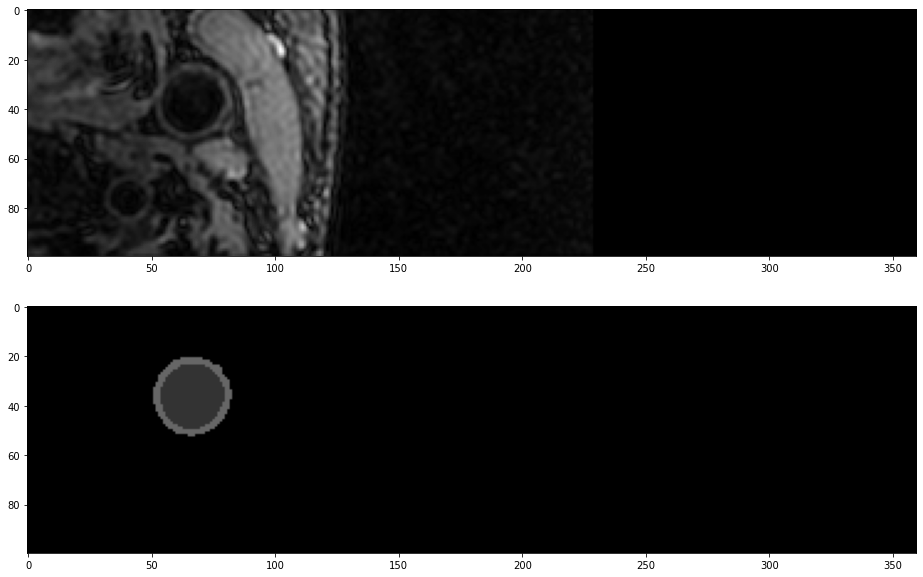



Validation:


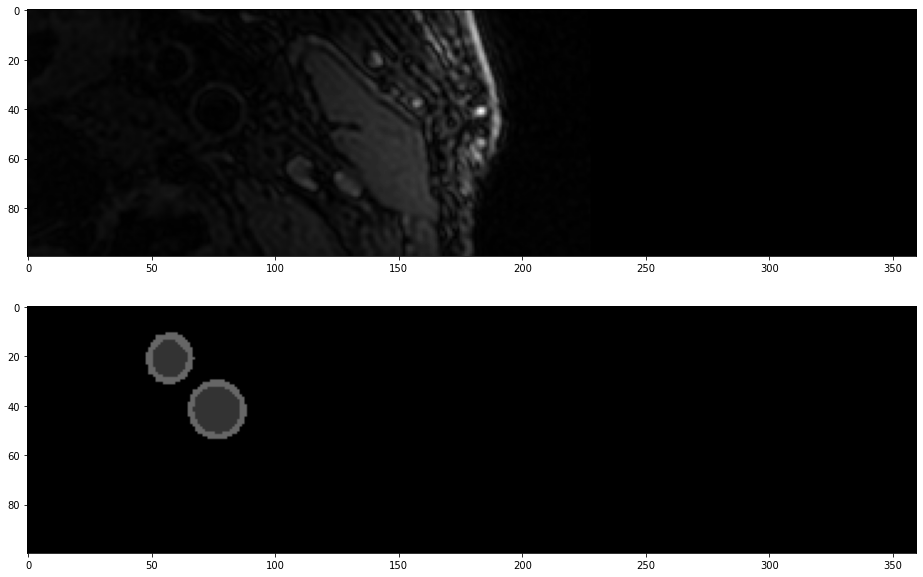

In [20]:
#------------Training:
img_ToVisualize = imread(newTrain_dir_left+'/'+'0_P3_U'+'/'+'EP3S101I386.png')    #Plot training
mask_ToVisualize = imread(newTrain_dir_left+'/'+'0_P3_U'+'/'+'EP3S101I386_mask.png')

print('Training:')
fig = px.imshow(mask_ToVisualize,title='Mask')
fig.show()

plt.figure(figsize=(40,10))
ax1 = plt.subplot(211)
ax1.imshow(img_ToVisualize, cmap=plt.cm.gray)
ax2 = plt.subplot(212)
ax2.imshow(mask_ToVisualize, cmap=plt.cm.gray, vmin=0, vmax=2)
plt.show()

#------------Validation:
img_ToVisualize = imread(newVal_dir_left+'/'+'0_P27_U'+'/'+'EP27S101I324.png')   #Plot validation
mask_ToVisualize = imread(newVal_dir_left+'/'+'0_P27_U'+'/'+'EP27S101I324_mask.png')

print('\n\nValidation:')
fig = px.imshow(mask_ToVisualize,title='Mask')
fig.show()

plt.figure(figsize=(40,10))
ax1 = plt.subplot(211)
ax1.imshow(img_ToVisualize, cmap=plt.cm.gray)
ax2 = plt.subplot(212)
ax2.imshow(mask_ToVisualize, cmap=plt.cm.gray, vmin=0, vmax=2)
plt.show()
